In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def hist_equ(input_image):
    # number of pixel
    N = input_image.shape[0] * input_image.shape[1]
    # histogram
    input_hist, _ = np.histogram(input_image.flatten(), 256, [0, 256])
    input_hist = input_hist/N
    # cumulative histogram
    cdf = input_hist.cumsum() #implicitly converted to float64
    # histogram equalization
    output_image = np.zeros(input_image.shape, dtype=input_image.dtype)
    output_image = 255 * cdf[input_image]
    output_image = output_image.astype(np.uint8)
    output_hist, _ = np.histogram(output_image.flatten(), 256, [0, 256])
    output_hist = output_hist/N
    return (output_image, output_hist, input_hist)

In [3]:
def hist_match(input_image, spec_hist):
    # number of pixel
    N = input_image.shape[0] * input_image.shape[1]
    # histogram
    input_hist, _ = np.histogram(input_image.flatten(), 256, [0, 256])
    input_hist = input_hist/N
    # equalized
    eq_img, eq_hist, _ = hist_equ(input_image)
    eq_hist_cdf = eq_hist.cumsum()  #is a functioni, input: pixel value, output: cumulative probability
    # normalized specified cumulative histogram
    spec_hist = spec_hist/spec_hist.sum()
    spec_cdf = spec_hist.cumsum()
    # transform function: inversing the equalized histogram
    temp = eq_hist_cdf[eq_img]  #mapping equalized image to its cumulative probability
    # mapping the cumulative probability to the specified cumulative probability
    output_image_flatten = np.argmin(np.abs(temp.flatten()[:,np.newaxis]-spec_cdf), axis=1).astype(np.uint8)   #find the closest value in spec_cdf, and return the index, using broadcastin
    output_image = output_image_flatten.reshape(input_image.shape)
    output_hist,_ = np.histogram(output_image_flatten, 256, [0, 256])
    output_hist = output_hist/N
    return (output_image, output_hist, input_hist)

In [4]:
def local_hist_equ(input_image, m_size):
    # number of pixel
    N = input_image.shape[0] * input_image.shape[1]
    # histogram
    input_hist, _ = np.histogram(input_image.flatten(), 256, [0, 256])
    input_hist = input_hist/N
    # padding, and ensure m_size is odd
    if m_size % 2 == 0:
        m_size += 1
    temp = np.pad(input_image, m_size//2, mode='constant', constant_values=0)
    # local histogram equalization
    output_image = np.zeros(input_image.shape, dtype=input_image.dtype)
    filter_N = m_size * m_size
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            temp_hist, _ = np.histogram(temp[i:i+m_size, j:j+m_size].flatten(), 256, [0, 256])
            temp_hist = temp_hist/filter_N
            cdf = temp_hist.cumsum()
            output_image[i, j] = 255 * cdf[input_image[i, j]]
    output_image = output_image.astype(np.uint8)
    output_hist, _ = np.histogram(output_image.flatten(), 256, [0, 256])
    output_hist = output_hist/N
    return (output_image, output_hist, input_hist)

In [5]:
def reduce_SAP(input_image, n_size):
    '''
    flipping the image at the edges would produce better results
    '''
    # padding, and ensure n_size is odd
    if n_size % 2 == 0:
        n_size += 1
    temp = np.pad(input_image, n_size//2, mode='constant', constant_values=0)

    output_image = np.zeros(input_image.shape, dtype=input_image.dtype)

    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            output_image[i, j] = np.median(temp[i:i+n_size, j:j+n_size])
    return output_image

This is a (500, 500) image, with datatype uint8


C:\Users\Tangent\AppData\Local\Temp\ipykernel_1864\1570128183.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


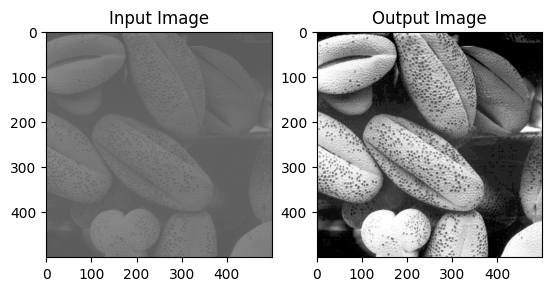

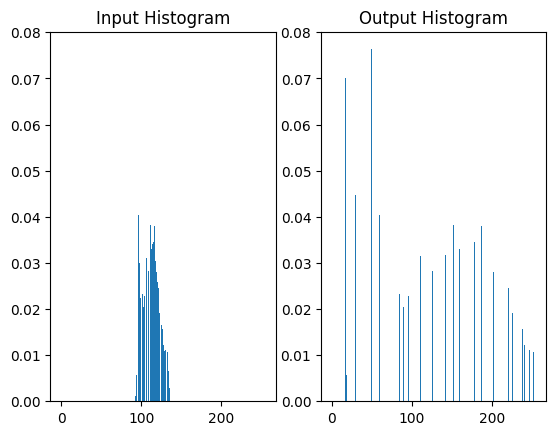

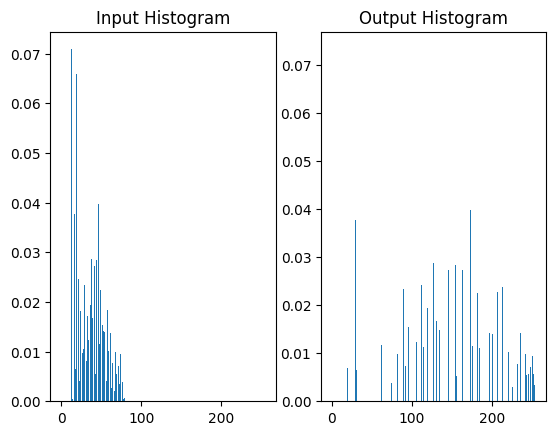

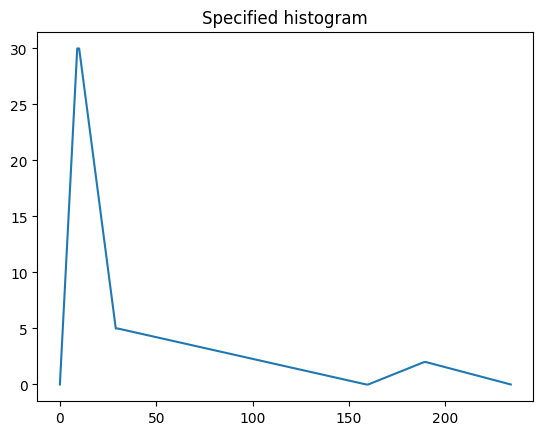

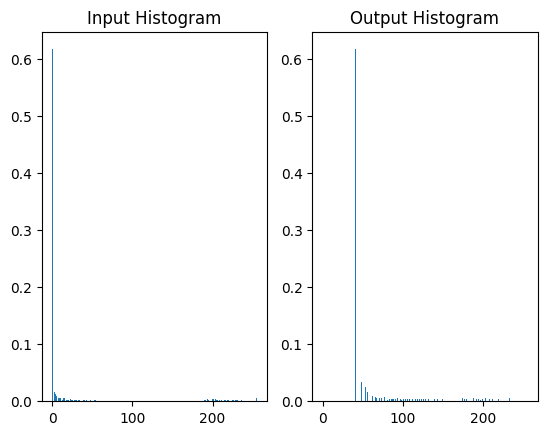

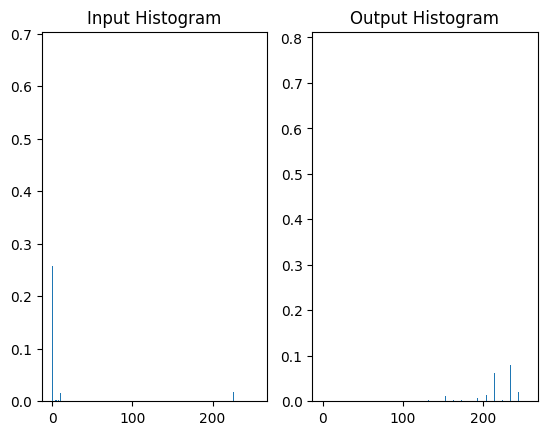

In [10]:
if __name__ == "__main__":
    # Read image
    test1_1 = plt.imread('in/Q3_1_1.tif')
    test1_2 = plt.imread('in/Q3_1_2.tif')
    test2 = plt.imread('in/Q3_2.tif')
    test3 = plt.imread('in/Q3_3.tif')
    test4 = plt.imread('in/Q3_4.tif')
    print(f"This is a {test1_1.shape} image, with datatype {test1_1.dtype}")

    arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.bar(np.array([1,2,3,4,5,6,7,8,9]),arr)

    # Histogram equalization
    output_image1_1, output_hist1_1, input_hist1_1 = hist_equ(test1_1)
    plt.subplot(1,2,1)
    plt.imshow(test1_1, cmap='gray',vmin=0, vmax=255)  # why it seems like the image has already been equalized? but add vmin and vmax can solve this problem
    plt.title('Input Image')
    plt.subplot(1,2,2)
    plt.imshow(output_image1_1, cmap='gray')
    plt.title('Output Image')
    plt.show()

    plt.subplot(1,2,1)
    plt.bar(np.arange(256), input_hist1_1)
    plt.title('Input Histogram')
    plt.subplot(1,2,2)
    plt.bar(np.arange(256), output_hist1_1)
    plt.title('Output Histogram')
    plt.show()

    img = Image.fromarray(output_image1_1)
    Image.fromarray(output_image1_1).save('out/Q3_1_1_output.jpg')

    output_image1_2, output_hist1_2, input_hist1_2 = hist_equ(test1_2)

    plt.subplot(1,2,1)
    plt.bar(np.arange(256), input_hist1_2)
    plt.title('Input Histogram')
    plt.subplot(1,2,2)
    plt.bar(np.arange(256), output_hist1_2)
    plt.title('Output Histogram')
    plt.show()

    img = Image.fromarray(output_image1_2)
    Image.fromarray(output_image1_2).save('out/Q3_1_2_output.jpg')

    # Histogram matching
    spec_hist = np.hstack((np.linspace(0,30,10),np.linspace(30,5,20),np.linspace(5,0,130),np.linspace(0,2,30),np.linspace(2,0,45)))
    plt.plot(spec_hist)
    plt.title('Specified histogram')
    plt.show()
    output_image2, output_hist2, input_hist2 = hist_match(test2,spec_hist)
    
    plt.subplot(1,2,1)
    plt.bar(np.arange(256), input_hist2)
    plt.title('Input Histogram')
    plt.subplot(1,2,2)
    plt.bar(np.arange(256), output_hist2)
    plt.title('Output Histogram')
    plt.show()

    img = Image.fromarray(output_image2)
    Image.fromarray(output_image2).save('out/Q3_2_output.jpg')

    # Local histogram equalization
    output_image3, output_hist3, input_hist3 = local_hist_equ(test3, 5)
    plt.subplot(1,2,1)
    plt.bar(np.arange(256), input_hist3)
    plt.title('Input Histogram')
    plt.subplot(1,2,2)
    plt.bar(np.arange(256), output_hist3)
    plt.title('Output Histogram')
    plt.show()

    img = Image.fromarray(output_image3)
    Image.fromarray(output_image3).save('out/Q3_3_output.jpg')

    # Reduce salt-and-pepper noise
    output_image4 = reduce_SAP(test4, 5)
    img = Image.fromarray(output_image4)
    Image.fromarray(output_image4).save('out/Q3_4_output.jpg')